In [1]:
import pandas as pd
import numpy as np
import ast
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import AgglomerativeClustering, DBSCAN
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from scipy.spatial.distance import pdist, squareform
from sklearn.preprocessing import MultiLabelBinarizer

## Preparation of the dataset

Drop all categorical columns and the rating columns, since we want to compare the clustering results with the rating.

In [3]:
df = pd.read_csv("../results/train_clean.csv", index_col=0)

In [4]:
df['countryOfOrigin'] = df['countryOfOrigin'].apply(ast.literal_eval)
df['genres'] = df['genres'].apply(ast.literal_eval)

In [5]:
df['genres'][0][0]

'Action'

In [6]:
df['logRuntime'] = np.log(df['runtimeMinutes'] + 1)

### Countries of Origin

We keep only the 4 most frequent countries of origin.

In [7]:
mbl = MultiLabelBinarizer()
countries_df = pd.DataFrame(mbl.fit_transform(df['countryOfOrigin']), columns=mbl.classes_, index=df.index)
countries_df = countries_df.astype('bool')
most_fr_countries = countries_df.sum().sort_values(ascending=False)
most_fr_countries.head(10)

US    7134
GB    1775
JP     846
FR     826
CA     621
IN     616
DE     502
IT     422
ES     325
AU     315
dtype: int64

In [8]:
countries_df = countries_df[most_fr_countries.head(4).index]
countries_df.head()

,US,GB,JP,FR
0,True,False,False,False
1,False,False,False,False
2,False,False,False,False
3,False,False,False,False
4,False,False,False,False


### Genres

We keep all genres.

In [9]:
genres_df = pd.DataFrame(mbl.fit_transform(df['genres']), columns=mbl.classes_, index=df.index)
genres_df = genres_df.astype('bool')
genres_df.sum().sort_values(ascending=False)

Drama          6175
Comedy         4839
Short          2464
Action         1957
Documentary    1835
Crime          1741
Adventure      1610
Animation      1487
Romance        1383
Family         1226
Thriller        785
Horror          688
Fantasy         656
Mystery         644
Music           554
Sci-Fi          449
Adult           433
Reality-TV      365
History         355
Talk-Show       338
Western         303
Biography       277
Game-Show       250
Sport           229
Musical         228
War             211
News            159
Film-Noir        27
dtype: int64

### Numeric columns

We drop the rating for the clustering

In [10]:
numeric_cols = df.dtypes[(df.dtypes == 'float64') | (df.dtypes == 'int64')].index
numeric_df = df[numeric_cols]
numeric_df.drop(['ratingNum', 'runtimeMinutes'], axis=1, inplace=True)
numeric_df.head()

/tmp/ipykernel_40597/3593668146.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  numeric_df.drop(['ratingNum', 'runtimeMinutes'], axis=1, inplace=True)


,startYear,numVotes,totalImages,totalCredits,numRegions,numGenres,criticReviewsRatio,logRuntime
0,1995,6.659294,0.693147,3.091042,0.693147,3,1.000000,3.713572
1,1982,2.484907,0.693147,0.693147,0.693147,1,0.000000,3.367296
2,1992,3.663562,0.693147,3.218876,0.693147,1,0.000000,4.510860
3,2021,2.772589,3.135494,4.043051,0.693147,1,0.000000,3.465736
4,2020,9.662625,5.852202,3.871201,3.496508,3,0.008772,4.394449


### TitleType

In [11]:
title_df = pd.get_dummies(df['titleType'], columns=['titleType'], drop_first=True)
title_df.head()

,short,tvEpisode,tvMiniSeries,tvMovie,tvSeries,tvShort,tvSpecial,video,videoGame
0,False,True,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,True
2,False,False,False,False,False,False,False,False,False
3,False,False,False,False,True,False,False,False,False
4,False,False,False,False,True,False,False,False,False


### Boolean columns

In [12]:
bool_cols = df.dtypes[df.dtypes == 'bool'].index
bool_df = df[bool_cols]
bool_df.head()

,canHaveEpisodes,awardsAndNominations,hasVideos,moreCountriesOfOrigin
0,False,False,False,False
1,False,False,False,False
2,False,False,False,False
3,True,False,False,False
4,True,True,True,False


## Precompute distance matrix

We need to precompute a distance matrix in order to use also categorical variables.
We compute a distance matrix from the numeric columns using the euclidean distance after normalizing the features. We compute matrices for countries of origin, genres, title type and the original boolean columns using the jaccard distance.
We will obtain a final distance matrix summing the distances from all the matrices.

In [13]:
scaler = StandardScaler()
numeric_df = scaler.fit_transform(numeric_df)

In [14]:
distance_matrix = pdist(numeric_df, metric='euclidean')
del numeric_df
# distance_matrix += pdist(bool_df, metric='jaccard')
del bool_df
# distance_matrix += pdist(countries_df, metric='jaccard')
del countries_df
# distance_matrix += pdist(genres_df, metric='jaccard')
del genres_df
# distance_matrix += pdist(title_df, metric='jaccard')
del title_df

In [15]:
distance_matrix = squareform(distance_matrix)

In [16]:
distance_matrix.shape

(16431, 16431)

## Clustering

In [17]:
def get_linkage_matrix(model):
    # Create linkage matrix

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    return linkage_matrix

def plot_dendrogram(model, **kwargs):
    linkage_matrix = get_linkage_matrix(model)
    dendrogram(linkage_matrix, **kwargs)

With the distance matrix given by the euclidean distance of numeric features and the jaccard distance of `canHaveEpisodes`, `awardsAndNominations`, `hasVideos` and `moreCountriesOfOrigin`, the best results are obtained with complete linkage.

In [18]:
hier_single = AgglomerativeClustering(distance_threshold=0,
                                      n_clusters=None,
                                      metric='precomputed',
                                      linkage='single')
hier_single.fit(distance_matrix)

AgglomerativeClustering(distance_threshold=0, linkage='single',
                        metric='precomputed', n_clusters=None)

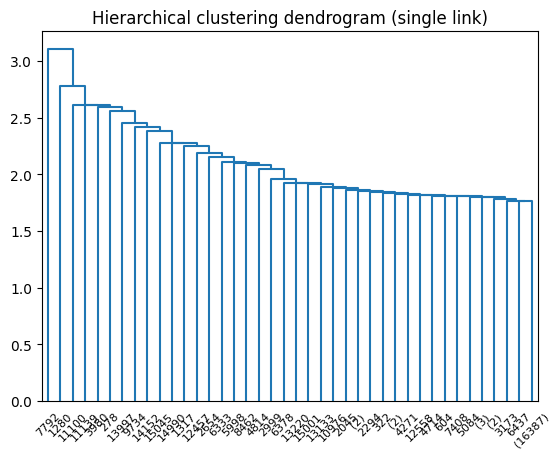

In [19]:
plt.title("Hierarchical clustering dendrogram (single link)")
plot_dendrogram(hier_single, truncate_mode="lastp", p=40,  color_threshold=0)
plt.show()

In [20]:
hier_average = AgglomerativeClustering(distance_threshold=0,
                                       n_clusters=None,
                                       metric='precomputed',
                                       linkage='average')
hier_average.fit(distance_matrix)

AgglomerativeClustering(distance_threshold=0, linkage='average',
                        metric='precomputed', n_clusters=None)

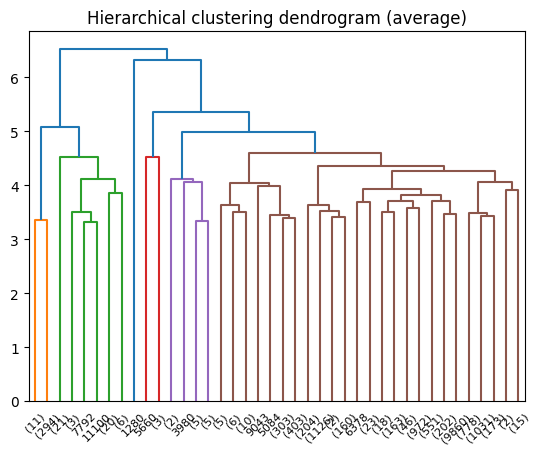

In [21]:
threshold = 4.7

plt.title("Hierarchical clustering dendrogram (average)")
plot_dendrogram(hier_average, truncate_mode="lastp", p=40,  color_threshold=threshold)
plt.show()

In [22]:
Z = get_linkage_matrix(hier_average)
labels = fcluster(Z, t=threshold, criterion='distance')
silhouette_score(distance_matrix, labels, metric='precomputed')

np.float64(0.2056172633044429)

In [23]:
np.unique(labels, return_counts=True)

(array([1, 2, 3, 4, 5, 6], dtype=int32),
 array([  305,    52,     4,    13, 16056,     1]))

Average linkage returns a very big cluster and several really small clusters.

In [24]:
df['c_average'] = labels

In [25]:
hier_complete = AgglomerativeClustering(distance_threshold=0,
                                n_clusters=None,
                                metric='precomputed',
                                linkage='complete')
hier_complete.fit(distance_matrix)

AgglomerativeClustering(distance_threshold=0, linkage='complete',
                        metric='precomputed', n_clusters=None)

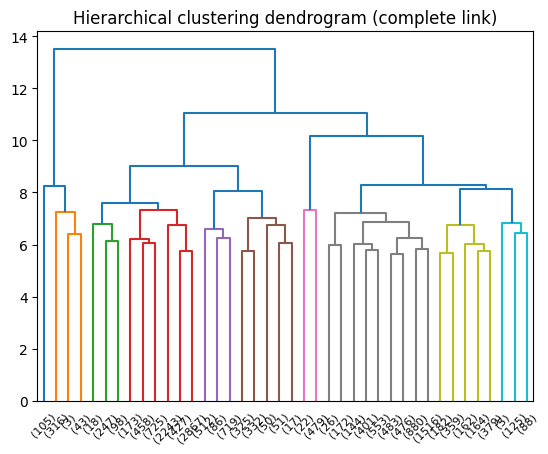

In [26]:
threshold = 7.5

plt.title("Hierarchical clustering dendrogram (complete link)")
plot_dendrogram(hier_complete, truncate_mode="lastp", p=40,  color_threshold=threshold)
plt.show()

In [27]:
Z = get_linkage_matrix(hier_complete)
labels = fcluster(Z, t=threshold, criterion='distance')
silhouette_score(distance_matrix, labels, metric='precomputed')

np.float64(0.05594539455969585)

In [28]:
np.unique(labels, return_counts=True)

(array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10], dtype=int32),
 array([ 105,  362,  363, 6893, 1317,  775,  501, 4651, 1246,  218]))

In [29]:
df['c_complete'] = labels

## Analysis of clusters

### Average linkage

Text(0.5, 1.0, 'Clusters (average) against title type')

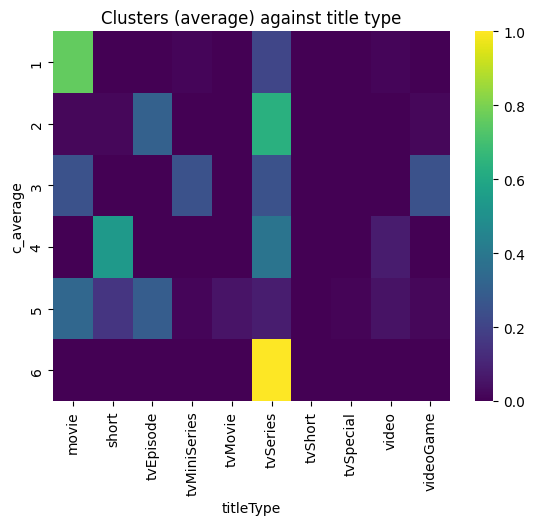

In [30]:
sns.heatmap(pd.crosstab(df['c_average'], df['titleType'],
                        normalize='index'),
                        cmap='viridis')
plt.title("Clusters (average) against title type")

### Complete linkage

Text(0.5, 1.0, 'Clusters (complete link) against title type')

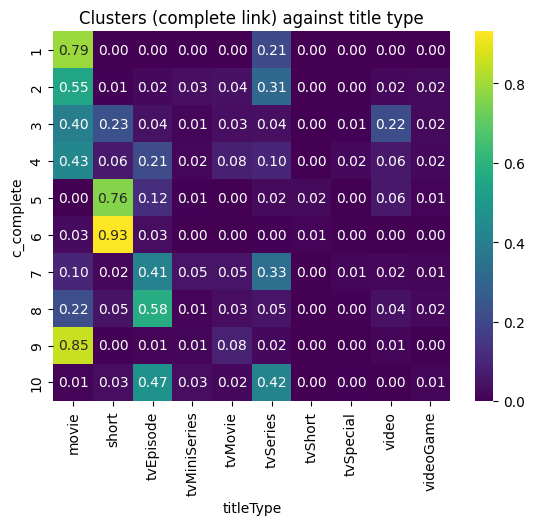

In [31]:
sns.heatmap(pd.crosstab(df['c_complete'], df['titleType'],
                        normalize='index'),
                        cmap='viridis',
                        annot=True,
                        fmt='.2f'
                        )
plt.title("Clusters (complete link) against title type")

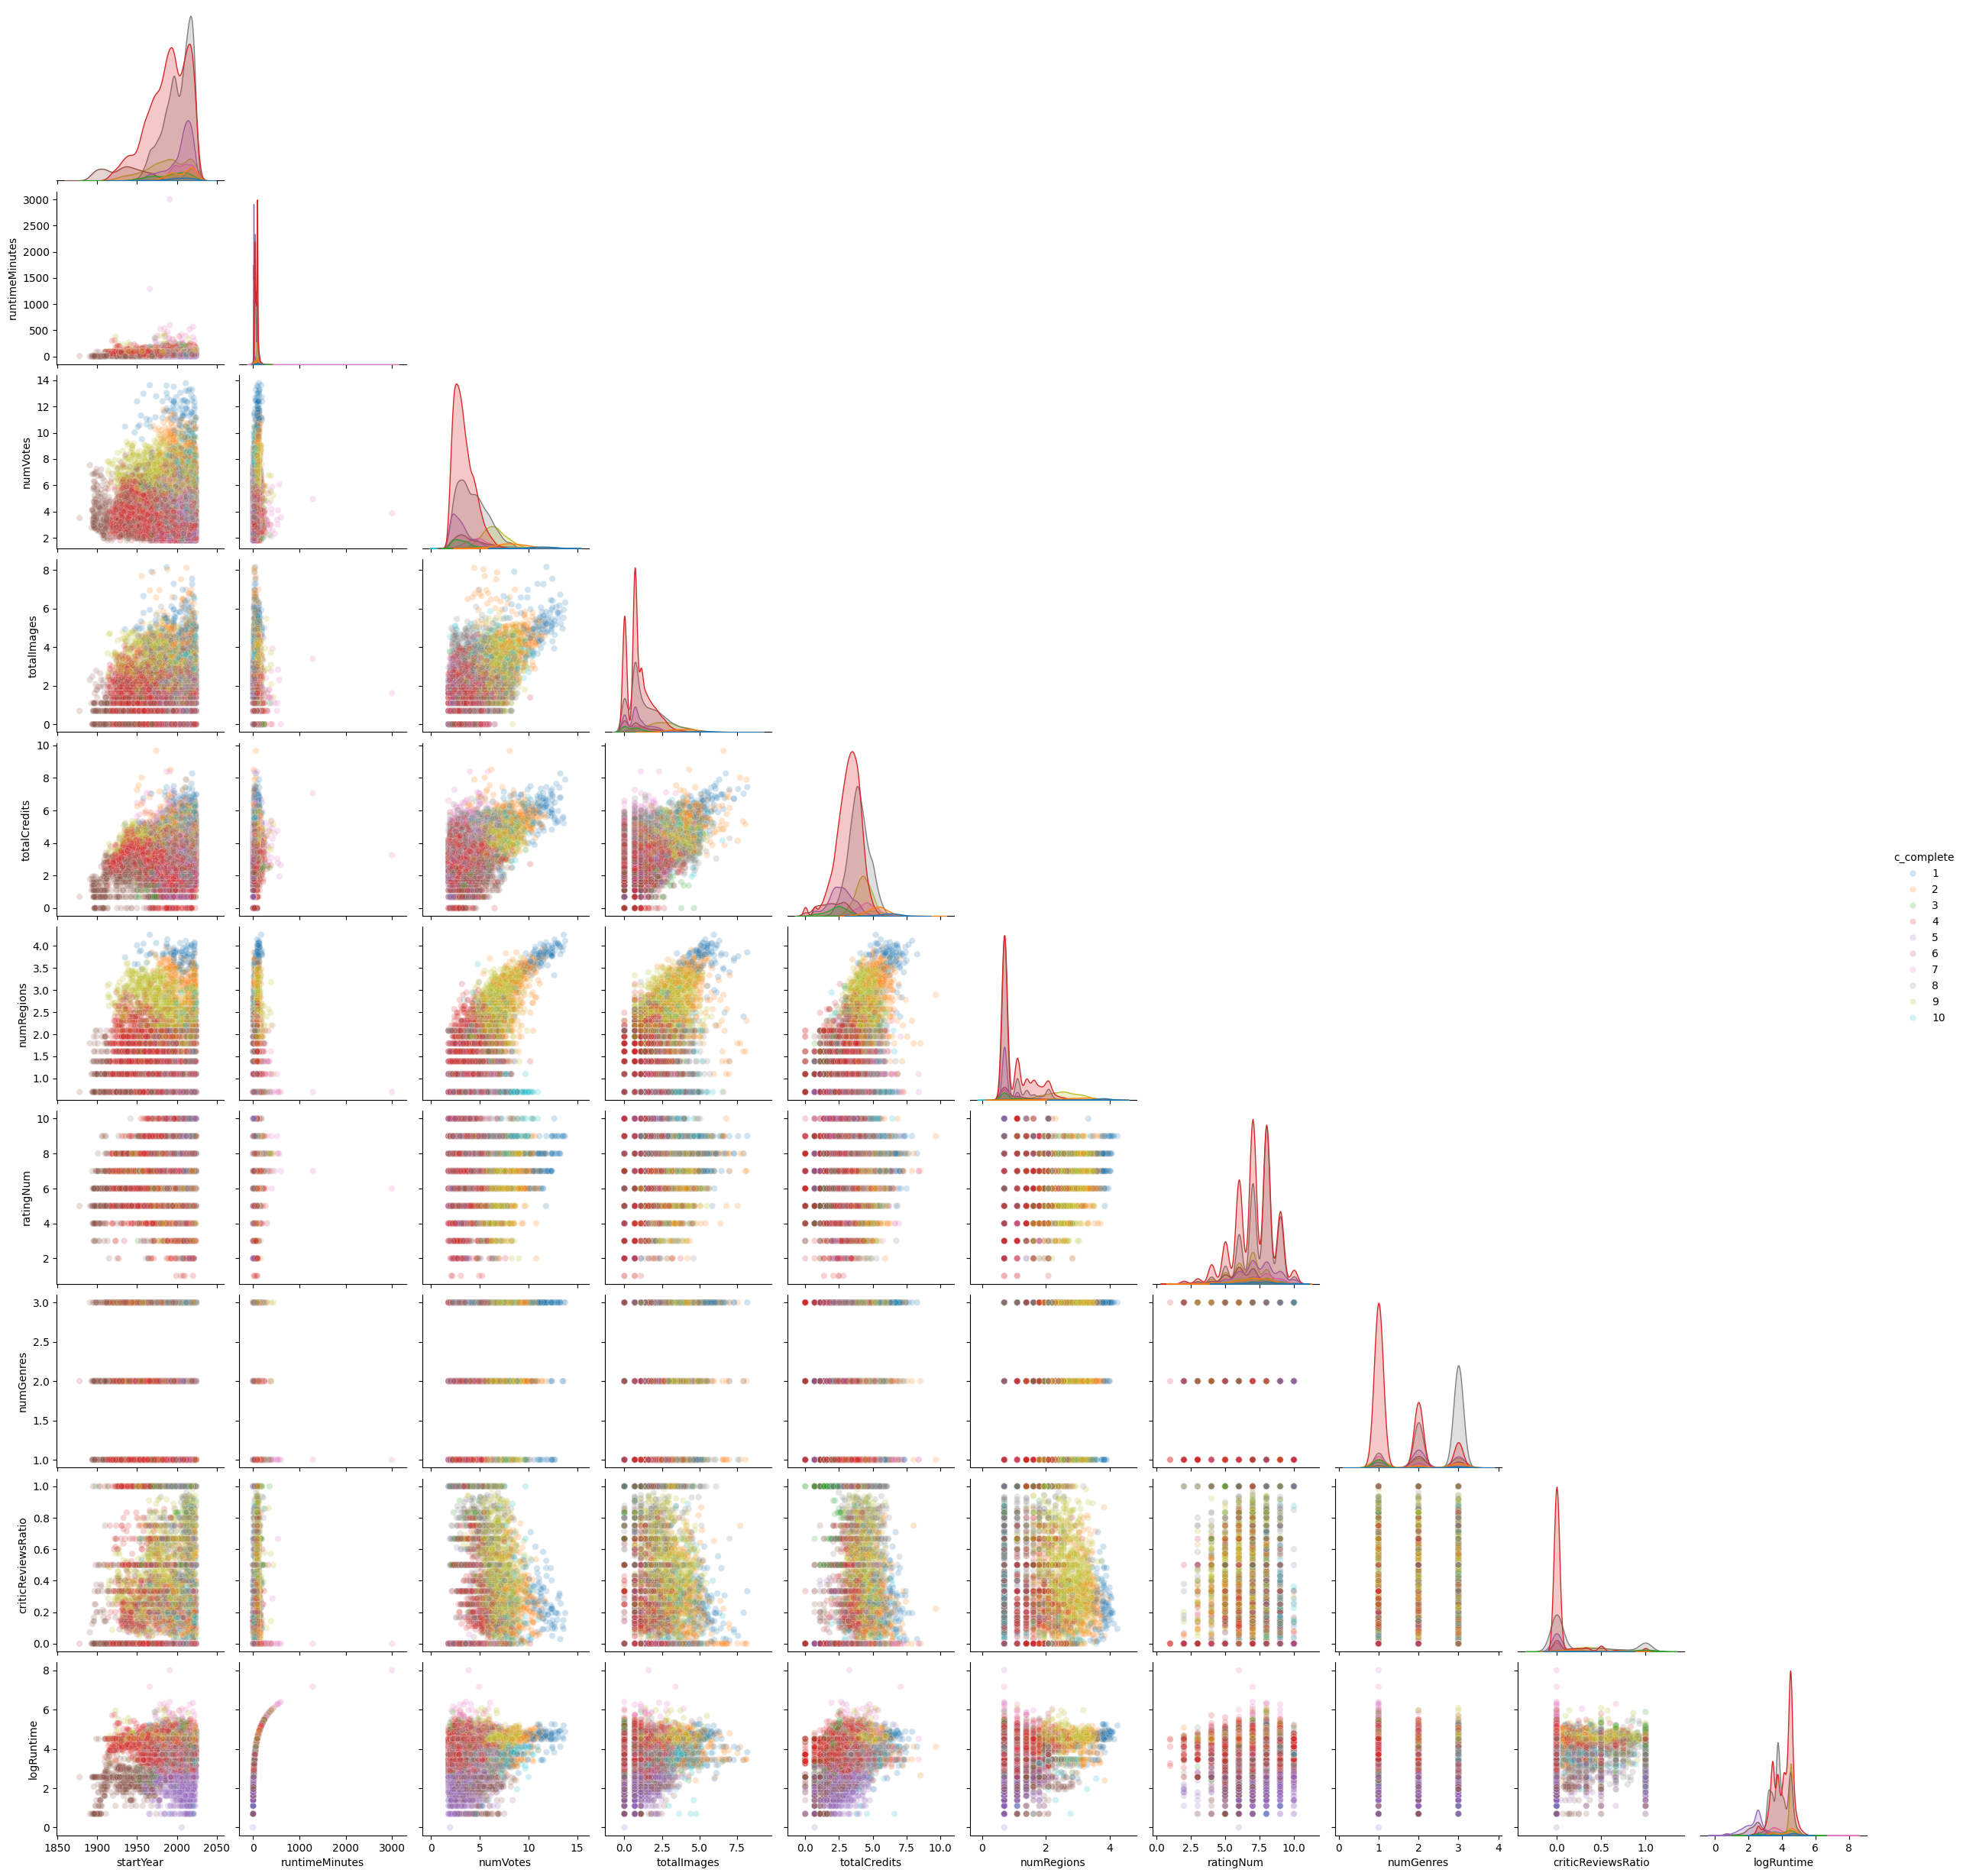

In [49]:
df['c_complete'] = pd.Categorical(df['c_complete'])
sns.pairplot(df[list(numeric_cols) + ['c_complete']], hue='c_complete', corner=True, plot_kws={'alpha':.2})

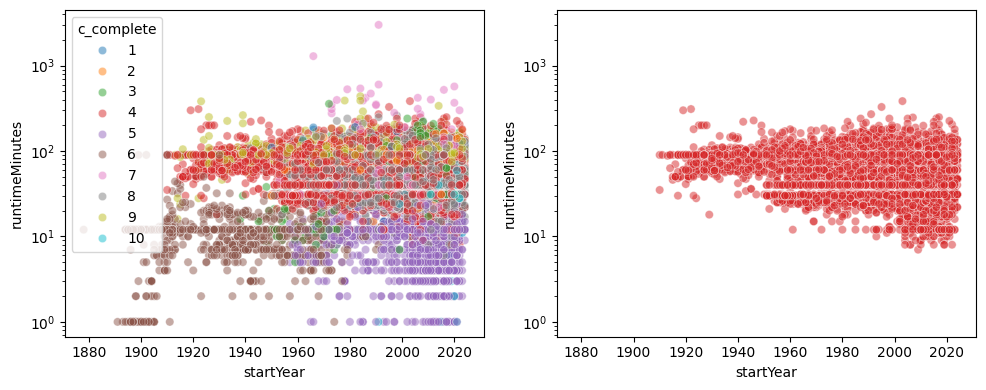

In [33]:
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
g = sns.scatterplot(df, x='startYear', y="runtimeMinutes", hue='c_complete', alpha=.5)
plt.yscale('log')
plt.subplot(1, 2, 2)
sns.scatterplot(df[df['c_complete'] == 4], x='startYear', y="runtimeMinutes", hue='c_complete', alpha=.5, legend=False)
plt.yscale('log')
plt.ylim(g.get_ylim())
plt.xlim(g.get_xlim())
plt.tight_layout()

Here we can clearly see that the hierarchical clustering detected two clusters of shorts, that differ for date of release: cluster 6 contains older shorts, while cluster 5 contains shorts that were realeased from the 60s onwards. If we had selected a higher threshold for splitting the dendrogram, these two clusters would be merged together.
We can also see that cluster 4 (which is the most numerous), containing mainly movies and tv episodes is cleanly separated from the two shorts clusters by means of runtime.

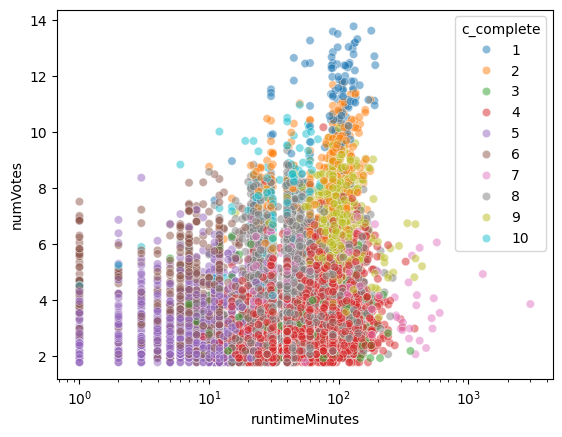

In [44]:
sns.scatterplot(df, x='runtimeMinutes', y='numVotes', hue='c_complete', alpha=.5)
plt.xscale('log')

<Axes: xlabel='numVotes', ylabel='Density'>

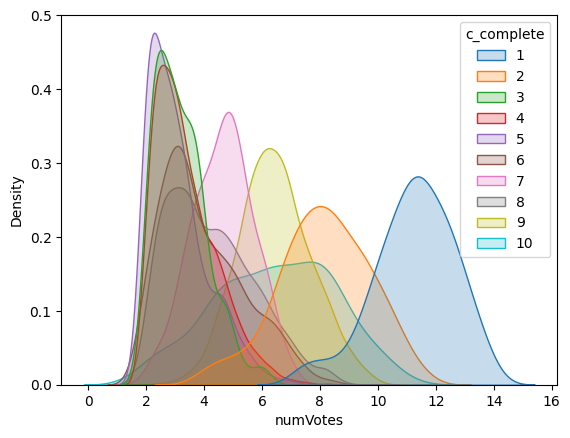

In [35]:
sns.kdeplot(df, x='numVotes', hue='c_complete', fill='c_complete', common_norm=False)

Here we can see that clusters 1 and 2, that contain maily movies and some TV series, were splitted with respect to the number of votes they received.
Both clusters contain records that are on average more popular than all other records in the dataset, but the ones clustered in cluster 2 were the most popular. Cluster 2 contains blockbusters like "Harry Potter and the Deathly Hallows - Part 2", "Il buono, il brutto, il cattivo" and "Full metal jacket", just to name a few, as well as very popular TV series like "The Witcher" and "Euphoria".

In [36]:
most_pop = df[df['c_complete'] == 1].sort_values('numVotes', ascending=False)
most_pop.head(20)

,originalTitle,rating,startYear,runtimeMinutes,numVotes,totalImages,totalCredits,titleType,canHaveEpisodes,numRegions,...,genres,ratingNum,numGenres,criticReviewsRatio,awardsAndNominations,hasVideos,moreCountriesOfOrigin,logRuntime,c_average,c_complete
3655,Harry Potter and the Deathly Hallows - Part 2,"(8, 9]",2011,130.0,13.781505,6.315358,7.902118,movie,False,4.110874,...,"[Adventure, Family, Fantasy]",9,3,0.194464,True,True,True,4.875197,1,1
988,"Il buono, il brutto, il cattivo","(8, 9]",1966,178.0,13.624271,5.937536,5.214936,movie,False,4.248495,...,"[Adventure, Drama, Western]",9,3,0.093350,True,True,True,5.187386,1,1
1694,Full Metal Jacket,"(8, 9]",1987,90.0,13.596293,5.521461,5.602119,movie,False,3.988984,...,"[Drama, War]",9,2,0.147899,True,True,True,4.510860,1,1
15166,Fargo,"(8, 9]",1996,98.0,13.510810,4.969813,5.517453,movie,False,3.891820,...,"[Crime, Thriller]",9,2,0.110000,True,True,True,4.595120,1,1
4192,Hacksaw Ridge,"(8, 9]",2016,139.0,13.324504,5.225747,6.812345,movie,False,3.970292,...,"[Biography, Drama, History]",9,3,0.254568,True,True,False,4.941642,1,1
7672,The Witcher,"(7, 8]",2019,60.0,13.274239,6.736967,8.275376,tvSeries,True,3.806662,...,"[Action, Adventure, Drama]",8,3,0.028993,True,True,True,4.110874,1,1
2867,American Sniper,"(7, 8]",2014,133.0,13.195794,6.169611,6.768493,movie,False,4.007333,...,"[Action, Biography, Drama]",8,3,0.318780,True,True,False,4.897840,1,1
681,Mission: Impossible - Ghost Protocol,"(7, 8]",2011,132.0,13.188870,5.768321,7.406711,movie,False,3.970292,...,"[Action, Adventure, Thriller]",8,3,0.306000,True,True,True,4.890349,1,1
4209,Hauru no ugoku shiro,"(8, 9]",2004,119.0,13.046206,5.811141,5.968708,movie,False,4.060443,...,"[Adventure, Animation, Family]",9,3,0.287197,True,True,True,4.787492,1,1
10686,The Princess Bride,"(7, 8]",1987,98.0,13.033128,5.509388,5.356586,movie,False,4.043051,...,"[Adventure, Comedy, Family]",8,3,0.191318,True,True,False,4.595120,1,1


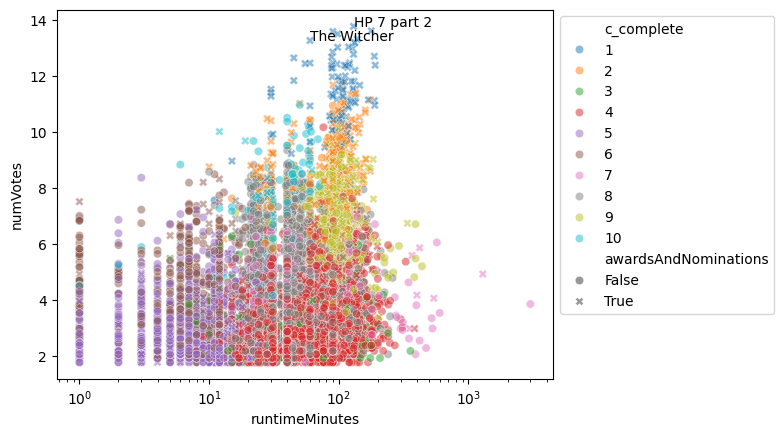

In [102]:
hp = most_pop.loc[3655]
witcher = most_pop.loc[7672]
sns.scatterplot(df, x='runtimeMinutes', y='numVotes', hue='c_complete', alpha=.5, style='awardsAndNominations')
plt.annotate('HP 7 part 2', xy=(hp['runtimeMinutes'], hp['numVotes']))
plt.annotate(witcher['originalTitle'],xy=(witcher['runtimeMinutes'], witcher['numVotes']))
plt.xscale('log')
plt.legend(bbox_to_anchor=(1, 1))

In [79]:
by_cluster = df.groupby('c_complete')
by_cluster[bool_cols].sum() / by_cluster[bool_cols].count()

/tmp/ipykernel_40597/695420170.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  by_cluster = df.groupby('c_complete')


,canHaveEpisodes,awardsAndNominations,hasVideos,moreCountriesOfOrigin
c_complete,,,,
1,0.209524,0.961905,0.942857,0.380952
2,0.342541,0.654696,0.720994,0.248619
3,0.049587,0.201102,0.030303,0.063361
4,0.113594,0.117075,0.040911,0.051066
5,0.028853,0.213364,0.055429,0.037206
6,0.003871,0.049032,0.003871,0.003871
7,0.381238,0.187625,0.095808,0.055888
8,0.060202,0.113094,0.078048,0.060847
9,0.033708,0.432584,0.330658,0.206260


In [84]:
df[bool_cols].sum() / df[bool_cols].count()

canHaveEpisodes          0.097316
awardsAndNominations     0.166697
hasVideos                0.097986
moreCountriesOfOrigin    0.069746
dtype: float64

Moreover, almost all (96%) records from cluster 1 received awards or nominations and almost all of them (94%) have attached videos on their IMDB page.
Of the slightly less popular records from cluster 2, 65% received awards or nominations, while 72% have videos on their IMDB page, while the values for the entire database are much lower (respectively 17% and 10%).

This is an interesting result, since we only used the numerical features for the clustering.

## Visualization of clusters

In [85]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, init='random', metric='precomputed')
reduced_df = pd.DataFrame(tsne.fit_transform(distance_matrix))

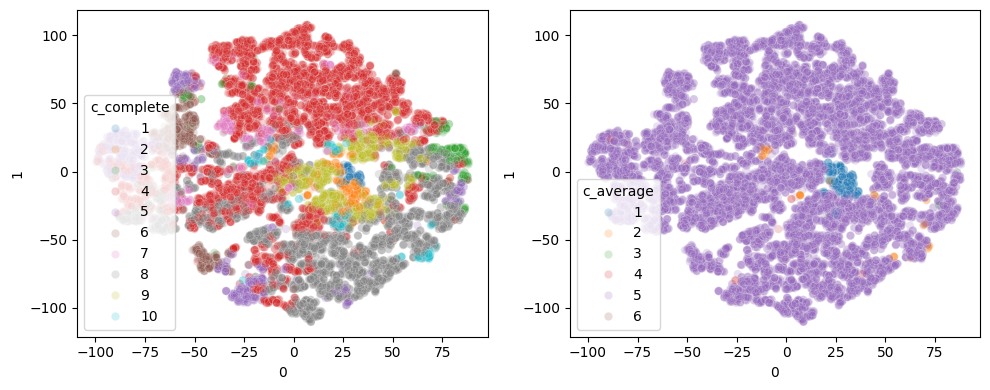

In [ ]:
reduced_df['c_complete'] = df['c_complete']
reduced_df['c_average'] = df['c_average']
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
sns.scatterplot(reduced_df, x=0, y=1, hue='c_complete', palette='tab10', alpha=.2)
plt.subplot(1, 2, 2)
sns.scatterplot(reduced_df, x=0, y=1, hue='c_average', palette='tab10', alpha=.2)
plt.tight_layout()